# Purpose: 
Generate a fire perimeter in GeoJSON based on the input pre and post flight images

In [1]:
import sys
from pathlib import Path

# Add the path to the utils folder to sys.path
utils_path = Path("/shared/Wildfire/Bety_wildfire_project/Bety_A_S_code/wildfire_HV_logratio/uavsar-main/python").resolve()
sys.path.append(str(utils_path))

import numpy as np
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from pathlib import Path
from rasterio.plot import show
# from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from process_utils import (preprocess_data, 
                           superpixel_segmentation,
                           get_superpixel_model_labels,
                           convert_labels_to_gdf,
                           filter_by_area,
                           merge_geojson,
                           tv_denoise,)
from nd_utils import (get_superpixel_means_as_features,
                      get_superpixel_stds_as_features,get_superpixel_medians_as_features,
                      get_array_from_features)
# # from process_utils import (preprocess_data, 
#                            get_model_labels)
from rio_utils import (reproject_arr_to_match_profile)
from shapely.geometry import Polygon
from shapely.geometry import Point

In [2]:
def denoise(data, weight):
    mask = np.isnan(data)
    data[mask] = 9999
    data_tv = tv_denoise(data, weight)
    data_tv[mask] = np.nan

    return data_tv

---
## Load the images into arrays

**Parameter**:
- `tifs` (list): a list containing the paths to the preprocessed images
- `superpixel_labels_list` (list): a list containing the paths to the superpixel labels

In [3]:
def open_one(path):
    with rasterio.open(path) as ds:
        band = ds.read(1)
        profile = ds.profile
        transform = ds.transform
    return band, profile, transform

In [4]:
# Path to the folder with the preprocessed images
data_dir = Path("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km")

tifs = sorted(list(data_dir.glob('./*rectangle_preprocessed*.tif')))
tifs

[PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/hv_0_45km_40km_rectangle_preprocessed_interpolated.tif'),
 PosixPath('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/hv_1_45km_40km_rectangle_preprocessed_interpolated.tif')]

---
Open the preprocessed images and load the superpixel segmentation corresponded to the pre- and post- fire.

- Let `hv_0` correspond to the pre-fire image and `hv_1` correspond to the post-fire image. 
- Let `profile` and `transform` correspond to the pre-fire image.
- Let `superpixel_labels` be the output of the segmentation

In [5]:
# open the tifs
bands_tv, profiles, transforms = zip(*map(open_one, tifs))
hv_0 = bands_tv[0]
hv_1 = bands_tv[1]
profile = profiles[0]
transform = transforms[0]

In [6]:
hv_0 = denoise(hv_0,5)
hv_1 = denoise(hv_1,5)

---
This is the preprocessed raster image we will work with to extract the fire perimeter

In [7]:
# compute log ratio and filter out the vegetation gain by setting to no change.
log_ratio = 10*np.log10(hv_0/hv_1)

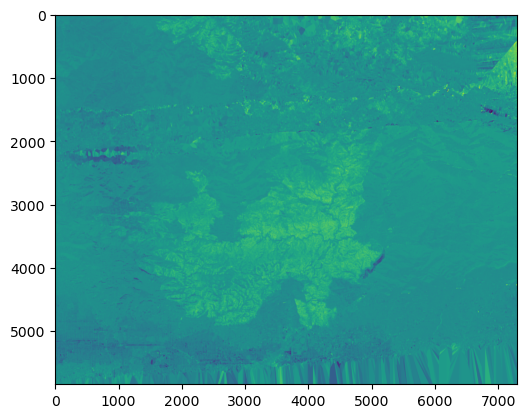

In [8]:
plt.imshow(log_ratio)

In [9]:
# Load if we have performed segmentation previously

superpixel_labels = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Hv_logratio_rectangle_45km_40km/superpixel_labels_230727_231017_min10000.npy")

In [10]:
# # Load if we have performed segmentation previously

# superpixel_labels = np.load("/shared/Wildfire/Jeremiah_Workspace/data/superpixel_labels_230727_231017_min1000.npy")

In [11]:
# # Run this if we do not have the saved np array

# superpixel_labels = superpixel_segmentation(hv_0, hv_1, min_size=100)

# # save this np array to save run time for future runs
# superpixel_out_path = "latuna_bilinear_inc.npy"
# np.save(superpixel_out_path, superpixel_labels)

In [12]:
print("superpizel_labels: ")
print(superpixel_labels)

superpizel_labels: 
[[  0   0   0 ...  25  25  25]
 [  0   0   0 ...  25  25  25]
 [  0   0   0 ...  25  25  25]
 ...
 [699 699 699 ... 690 690 690]
 [699 699 699 ... 690 690 690]
 [699 699 699 ... 690 690 690]]


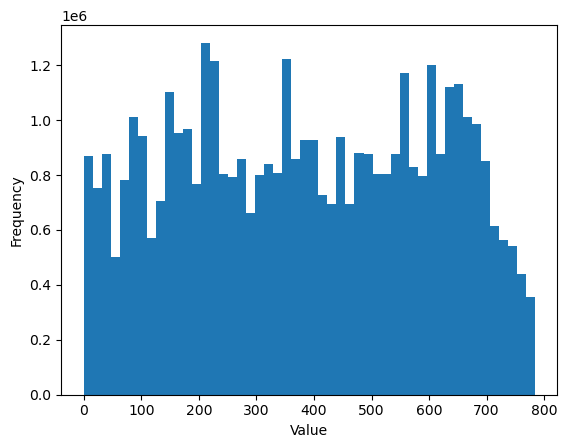

In [13]:
import matplotlib.pyplot as plt

# Check the distribution of the data
plt.hist(superpixel_labels.flatten(), bins=50)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Classification

In [14]:
# np.seterr(divide='ignore', invalid='ignore')##
# # Extracting features from the segmentation
# mean_features = get_superpixel_means_as_features(superpixel_labels, log_ratio)
# std_features = get_superpixel_stds_as_features(superpixel_labels, log_ratio)
# print("mean_features", mean_features)
# print("std_features", std_features)

In [15]:
pre_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/rectangle_45km_40km/pre_merged_alpha1_image_rectangle.npy")
post_alpha1 = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/post_rectangle_45km_40km/post_merged_alpha_image_test_aligned_rectangle.npy")
slope = np.load("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/Slope/slope_without_crop.npy")

In [16]:
# Get common minimum shape across all relevant inputs
min_rows = min(superpixel_labels.shape[0], log_ratio.shape[0], pre_alpha1.shape[0], post_alpha1.shape[0], slope.shape[0])
min_cols = min(superpixel_labels.shape[1], log_ratio.shape[1], pre_alpha1.shape[1], post_alpha1.shape[1], slope.shape[1])
print("min_rows", min_rows)
# Crop all arrays to the same shape
superpixel_labels_cropped = superpixel_labels[:min_rows, :min_cols]
log_ratio_cropped = log_ratio[:min_rows, :min_cols]
pre_alpha1_cropped = pre_alpha1[:min_rows, :min_cols]
post_alpha1_cropped = post_alpha1[:min_rows, :min_cols]
slope_cropped = slope[:min_rows, :min_cols]
print(superpixel_labels_cropped.shape)

# Feature extraction
np.seterr(divide='ignore', invalid='ignore')
mean_log_ratio = get_superpixel_means_as_features(superpixel_labels_cropped, log_ratio_cropped)
median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels_cropped, pre_alpha1_cropped)
median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels_cropped, post_alpha1_cropped)
diff_alpha1 = median_pre_alpha1 - median_post_alpha1
median_slope = get_superpixel_medians_as_features(superpixel_labels_cropped, slope_cropped)


min_rows 5839
(5839, 7290)


In [17]:
print("pre_alpha1", pre_alpha1.shape)

pre_alpha1 (5839, 7290)


In [18]:
print("post_alpha1", post_alpha1.shape)

post_alpha1 (5839, 7290)


In [19]:
print("slope", slope.shape)

slope (5839, 7290)


In [20]:
# np.seterr(divide='ignore', invalid='ignore')
# #Extracting features
# mean_log_ratio = get_superpixel_means_as_features(superpixel_labels, log_ratio)
# median_pre_alpha1 = get_superpixel_medians_as_features(superpixel_labels, pre_alpha1)
# median_post_alpha1 = get_superpixel_medians_as_features(superpixel_labels, post_alpha1)
# diff_alpha1 = median_pre_alpha1 - median_post_alpha1
# median_slope = get_superpixel_medians_as_features(superpixel_labels, slope)




In [21]:
unique_superpixel_labels = np.unique(superpixel_labels)
unique_superpixel_labels_reshape = unique_superpixel_labels.reshape(-1,1)

In [22]:
print(unique_superpixel_labels_reshape.shape)

(785, 1)


In [23]:
print(mean_log_ratio.shape)

(785, 1)


In [24]:
print(diff_alpha1.shape)

(785, 1)


In [25]:
print(median_slope.shape)

(785, 1)


In [26]:
# I need to check how to make a dataframe using these columns
fire_data = np.hstack([unique_superpixel_labels_reshape,mean_log_ratio, diff_alpha1, median_slope])

In [27]:
# unique_vals = np.unique(superpixel_labels)
# print("Unique values in superpixel_labels:", unique_vals)


In [28]:
index = 4
print(f"median_pre_alpha1[{index}] = {median_pre_alpha1[index]}")
print(f"median_post_alpha1[{index}] = {median_post_alpha1[index]}")
print(f"diff_alpha1[{index}] = {diff_alpha1[index]}")
print(f"Manual check: {median_pre_alpha1[index]} - {median_post_alpha1[index]} = {median_pre_alpha1[index] - median_post_alpha1[index]}")


median_pre_alpha1[4] = [31.39610625]
median_post_alpha1[4] = [23.79458809]
diff_alpha1[4] = [7.60151816]
Manual check: [31.39610625] - [23.79458809] = [7.60151816]


In [29]:
unique_vals = np.unique(diff_alpha1)
print("Unique values in diff_alpha1:", unique_vals)

Unique values in diff_alpha1: [-1.99849356e+01 -1.90526558e+01 -1.43301299e+01 -1.29064616e+01
 -1.26422823e+01 -1.14094240e+01 -1.00198795e+01 -9.94582737e+00
 -7.65184537e+00 -7.31966822e+00 -7.18179777e+00 -7.09321992e+00
 -7.06613085e+00 -7.00722842e+00 -6.95142469e+00 -6.90776579e+00
 -6.88894691e+00 -6.81974651e+00 -6.80742380e+00 -6.72361306e+00
 -6.64456831e+00 -6.53407350e+00 -6.39433922e+00 -6.33978584e+00
 -6.30208548e+00 -6.26840916e+00 -6.12969703e+00 -6.09226961e+00
 -5.98922811e+00 -5.95148972e+00 -5.75385990e+00 -5.74212570e+00
 -5.41531633e+00 -5.22218942e+00 -5.14414676e+00 -4.95241831e+00
 -4.85061012e+00 -4.84323867e+00 -4.80138177e+00 -4.78723419e+00
 -4.78018146e+00 -4.75092751e+00 -4.71385983e+00 -4.60058519e+00
 -4.55774188e+00 -4.55728470e+00 -4.54767280e+00 -4.49151264e+00
 -4.46229919e+00 -4.39910564e+00 -4.35257691e+00 -4.25675042e+00
 -4.25416239e+00 -4.20474092e+00 -4.12747312e+00 -4.10451684e+00
 -4.05814493e+00 -4.05749767e+00 -4.03975848e+00 -4.00403765

In [30]:
import pandas as pd
# Create pandas dataframe with column names
df = pd.DataFrame(fire_data, columns=['superpixel_label','mean_log_ratio', 'diff_alpha1', 'median_slope'])
print(df)

     superpixel_label  mean_log_ratio  diff_alpha1  median_slope
0                 0.0       -1.928298    -1.140254        1080.0
1                 1.0       -1.821903    -2.079386        1221.0
2                 2.0       -1.953732     0.596607        1291.0
3                 3.0       -1.488870     3.696622        1395.0
4                 4.0        0.549635     7.601518        1317.0
..                ...             ...          ...           ...
780             780.0       -3.683202          NaN         143.0
781             781.0       -2.588665          NaN         136.0
782             782.0       -3.612520          NaN         122.0
783             783.0       -0.088248          NaN         175.0
784             784.0       -0.306046          NaN         166.0

[785 rows x 4 columns]


In [31]:
# Calculate the number of non-null values in each row
non_null_counts = df.count(axis=1)

# Get the total number of columns
num_columns = df.shape[1]

# Determine complete rows
complete_rows = df[non_null_counts == num_columns]

# Count the number of complete rows
num_complete_rows = len(complete_rows)
print(num_complete_rows)

568


In [32]:
# retain only complete rows
df_cleaned = df.dropna()
print(len(df_cleaned))
# pd.set_option('display.max_rows',None)
print(df_cleaned)

568
     superpixel_label  mean_log_ratio  diff_alpha1  median_slope
0                 0.0       -1.928298    -1.140254        1080.0
1                 1.0       -1.821903    -2.079386        1221.0
2                 2.0       -1.953732     0.596607        1291.0
3                 3.0       -1.488870     3.696622        1395.0
4                 4.0        0.549635     7.601518        1317.0
..                ...             ...          ...           ...
687             687.0       -2.903463    -2.942155         207.0
697             697.0       -2.886399    -1.595006         176.0
698             698.0       -3.495086    -6.888947         156.0
704             704.0       -3.232934    -3.363333         196.0
708             708.0       -4.443947   -12.642282         142.0

[568 rows x 4 columns]


In [33]:
df_cleaned_for_model = df_cleaned.drop('superpixel_label', axis=1) # we don't want to use the superpixel label as a feature
print(df_cleaned_for_model)

     mean_log_ratio  diff_alpha1  median_slope
0         -1.928298    -1.140254        1080.0
1         -1.821903    -2.079386        1221.0
2         -1.953732     0.596607        1291.0
3         -1.488870     3.696622        1395.0
4          0.549635     7.601518        1317.0
..              ...          ...           ...
687       -2.903463    -2.942155         207.0
697       -2.886399    -1.595006         176.0
698       -3.495086    -6.888947         156.0
704       -3.232934    -3.363333         196.0
708       -4.443947   -12.642282         142.0

[568 rows x 3 columns]


In [34]:
from sklearn.cluster import KMeans
# model = KMeans(n_clusters=4, ##3
#               n_init=4,
#               random_state=1)
# classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = classes + 1
# classes
# Selecting the K-Means model with n_clusters=2
model = KMeans(n_clusters=2, n_init=10,random_state=1)

In [35]:
# labeled_data = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = get_array_from_features(superpixel_labels, labeled_data)
# gdf = convert_labels_to_gdf(classes, profile)


In [36]:
classes = get_superpixel_model_labels(df_cleaned_for_model, model)
# classes = get_array_from_features(superpixel_labels, labeled_data)
# # gdf = convert_labels_to_gdf(classes, profile)

In [37]:
# print(len(classes))

print(df_cleaned.shape)

(568, 4)


In [38]:
# Dr.Uma Code
model_output = superpixel_labels
# model_output = np.empty_like(superpixel_labels)
# model_output[:] = 0 # 0 indicates missing values since classes are numbered 1, 2, ...

for i in range(len(classes)):
    # print(i)
    # print(df_cleaned.iat[i,0])
    # print(classes[i])
    model_output[model_output==int(df_cleaned.iat[i,0])] = classes[i]
    # model_output = np.where(model_output == int(df_cleaned.iat[i,0]),classes[i],0) # logically this is correct
    # np.put(model_output,np.where(model_output==int(df_cleaned.iat[i,0])),classes[i])
    # model_output.replace(df_cleaned.iat[i,0],classes[i])
# print(superpixel_labels)
# print(model_output)

In [39]:
print(model_output)

[[  0   0   0 ...  25  25  25]
 [  0   0   0 ...  25  25  25]
 [  0   0   0 ...  25  25  25]
 ...
 [699 699 699 ... 690 690 690]
 [699 699 699 ... 690 690 690]
 [699 699 699 ... 690 690 690]]


In [40]:
print(np.unique(model_output))

[  0   1  10  11  12  13  14  15  16  17  18  20  21  22  23  24  25  28
  30  32  33  34  36  38  39  40  41  42  48  49  50  52  53  58  59  60
  61  64  65  66  67  70  72  73  74  76  77  78  81  84  87  88  89  91
  92  94  95  96  97  99 103 106 107 108 109 112 114 115 116 117 118 119
 120 121 123 125 130 132 135 136 141 142 143 147 153 155 157 164 166 170
 171 176 182 187 202 203 225 239 564 612 617 618 623 630 633 635 637 640
 641 642 646 650 654 656 659 660 667 670 672 673 677 680 681 682 684 686
 688 689 690 691 692 693 694 695 696 699 700 701 702 703 705 706 707 709
 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727
 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745
 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763
 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781
 782 783 784]


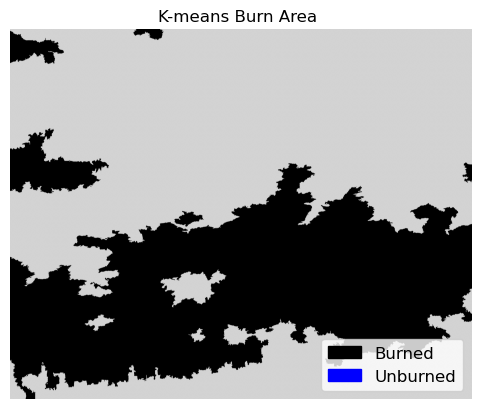

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

# Assume model_output is a 2D numpy array of K-means labels
# Example: model_output = kmeans.labels_.reshape(height, width)

# Define color scheme for K-means clusters
# You can expand or adjust depending on how many clusters you have
colors = ['lightgray'] * 10  # default color
colors[1] = 'black'          # burned
colors[2] = 'blue'           # unburned (or use 'green' if you prefer)

# Define legend labels for known classes
class_names = {
    1: "Burned",
    2: "Unburned"
}

# Create colormap and normalization
cmap = mcolors.ListedColormap(colors)
bounds = np.arange(len(colors) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create legend patches
legend_patches = [
    mpatches.Patch(color=colors[i], label=class_names[i]) for i in class_names
]

# Plot
plt.imshow(model_output, cmap=cmap, norm=norm)
plt.title('K-means Burn Area ')
plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.axis('off')
plt.show()


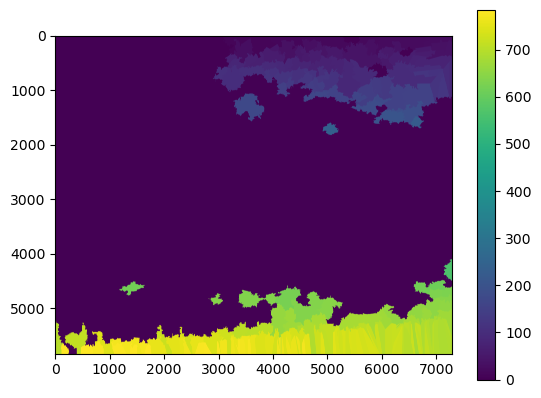

In [43]:
plt.imshow(model_output)
plt.colorbar()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Load label map
label_map = model_output.astype(np.uint8)

# Step 2: Define RGB colors for classes
class_colors = {
    1: [139, 69, 19],   # brown → using orange
    2: [0, 128, 0],     # green → using green
    3: [255, 255, 0],   # yellow → using yellow
    4: [255, 0, 0]      # red → using red
      # red
}

# Optional: define class names (optional but useful for legend)
class_names = {
    1: "Orange",
    2: "Green",
    3: "Yellow",
    4: "Red"
}

# Step 3: Create full white background
H, W = label_map.shape
overlay_image = np.ones((H, W, 3), dtype=np.uint8) * 255  # white background

# Step 4: Apply color overlays
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

# Step 5: Display image
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Burn Severity Classification")


# Step 6: Create custom legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=class_names[class_label])
    for class_label, color in class_colors.items()
]

plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Load label map
label_map = model_output.astype(np.uint8)

# Step 2: Define RGB colors for classes (corrected orange color)
class_colors = {
    1: [255, 165, 0],   # orange
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Step 3: Define class names
class_names = {
    1: "Orange",
    2: "Green",
    3: "Yellow",
    4: "Red"
}

# Step 4: Create full white background
H, W = label_map.shape
overlay_image = np.ones((H, W, 3), dtype=np.uint8) * 255  # white background

# Step 5: Apply color overlays
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

# Step 6: Display image
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Burn Severity Classification")

# Step 7: Create custom legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=class_names[class_label])
    for class_label, color in class_colors.items()
]

plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Load label map
label_map = model_output.astype(np.uint8)

# Step 2: Define RGB colors for known classes
class_colors = {
    1: [255, 165, 0],   # orange
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Step 3: Define class names
class_names = {
    1: "Orange",
    2: "Green",
    3: "Yellow",
    4: "Red"
}

# Step 4: Create white background
H, W = label_map.shape
overlay_image = np.ones((H, W, 3), dtype=np.uint8) * 255  # white by default

# Step 5: Apply color overlays for known classes only
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

# Step 6: Display the result
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Burn Severity Classification")

# Step 7: Create custom legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=class_names[class_label])
    for class_label, color in class_colors.items()
]

# Optional: add a patch for undefined classes (background/white)
legend_patches.append(mpatches.Patch(color='white', label='Background'))

plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Load label map
label_map = model_output.astype(np.uint8)

# Step 2: Define RGB colors for known classes
class_colors = {
    1: [139, 69, 19],   # brown → using orange
    2: [0, 128, 0],     # green → using green
    3: [255, 255, 0],   # yellow → using yellow
    4: [255, 0, 0]      # red → using red
}

# Optional: define class names
class_names = {
    1: "Orange",
    2: "Green",
    3: "Yellow",
    4: "Red"
}

# Step 3: Create full white background
H, W = label_map.shape
overlay_image = np.ones((H, W, 3), dtype=np.uint8) * 255  # white background

# Step 4: Apply color overlays for known classes
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

# Step 5: Optionally handle undefined classes (already white, so no need to overwrite)

# Step 6: Display image
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Burn Severity Classification")

# Step 7: Create custom legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=class_names[class_label])
    for class_label, color in class_colors.items()
]

plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Step 1: Load label map
label_map = model_output.astype(np.uint8)

# Step 2: Define RGB colors for known classes
class_colors = {
    1: [255, 165, 0],   # orange
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Step 3: Define class names
class_names = {
    1: "Orange",
    2: "Green",
    3: "Yellow",
    4: "Red"
}

# Step 4: Create white background image (initialize with white)
H, W = label_map.shape
overlay_image = np.ones((H, W, 3), dtype=np.uint8) * 255  # pure white background

# Step 5: Apply color overlays for known classes
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

# Step 6: Explicitly set all pixels NOT belonging to known classes to white
# This is the key step to clean any leftover non-white pixels
known_class_mask = np.isin(label_map, list(class_colors.keys()))
for c in range(3):
    overlay_image[:, :, c][~known_class_mask] = 255  # set background pixels to white

# Step 7: Display the result
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Burn Severity Classification")

# Step 8: Create custom legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=class_names[class_label])
    for class_label, color in class_colors.items()
]

# Add background patch to legend
legend_patches.append(mpatches.Patch(color='white', label='Background'))

plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()


In [ ]:
import matplotlib.colors as mcolors
colors = ['white'] * 10  # A default color for other values
colors[0] = 'blue'
colors[1] = 'orange'
colors[2] = 'green'
colors[3] = 'yellow'
colors[4] = 'red'

cmap = mcolors.ListedColormap(colors)

bounds = np.arange(len(colors) + 1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.imshow(model_output, cmap=cmap, norm=norm)
plt.colorbar(ticks=np.arange(len(colors))) # Add a colorbar for reference
plt.title('Burn Severity Classification')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model_output is your 2D numpy array
plt.imsave("/shared/Wildfire/Bety_wildfire_project/Bety_data_test/burnserity.png", model_output, cmap='viridis')


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Step 1: Load the actual RGB background image
original_image = imread('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/burnserity.png')  # shape: (H, W, 3)

# Ensure it's in uint8 format
original_image = (original_image * 255).astype(np.uint8) if original_image.max() <= 1 else original_image

# Step 2: Load your label map (from model_output), assumed shape (H, W), values 0–4
label_map = model_output.astype(np.uint8)

# Step 3: Define RGB colors for classes
class_colors = {
    1: [139, 69, 19],   # brown → using orange
    2: [0, 128, 0],     # green → using green
    3: [255, 255, 0],   # yellow → using yellow
    4: [255, 0, 0]      # red → using red
}

# Step 4: Copy original image for overlay
overlay_image = original_image.copy()

# Step 5: Apply overlay colors on labeled areas only
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):  # R, G, B channels
        overlay_image[:, :, c][mask] = color[c]

# Step 6: Display
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)


plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Load your label map (from model_output), assumed shape (H, W), values 0–4
label_map = model_output.astype(np.uint8)

# Step 2: Define RGB colors for classes
class_colors = {
    1: [139, 69, 19],   # brown
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Step 3: Create a full white background image (H, W, 3)
H, W = label_map.shape
overlay_image = np.ones((H, W, 3), dtype=np.uint8) * 255  # white background

# Step 4: Apply overlay colors on labeled areas only
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):  # R, G, B channels
        overlay_image[:, :, c][mask] = color[c]

# Step 5: Display
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
#plt.title("Labeled Regions on Full White Background")

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import matplotlib.patches as mpatches

# Step 1: Load the actual RGB background image
original_image = imread('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/burnserity.png')  # shape: (H, W, 3)
original_image = (original_image * 255).astype(np.uint8) if original_image.max() <= 1 else original_image

# Step 2: Load your label map (from model_output), assumed shape (H, W), values 0–4
label_map = model_output.astype(np.uint8)

# Step 3: Define RGB colors for classes
class_colors = {
    1: [139, 69, 19],   # brown
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Optional: class names for the legend
class_names = {
    1: "orange",
    2: "Unburned to very low",
    3: "Low Severity",
    4: "High"
}

# Step 4: Copy original image for overlay
overlay_image = original_image.copy()

# Step 5: Apply overlay colors on labeled areas only
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):  # R, G, B channels
        overlay_image[:, :, c][mask] = color[c]

# Step 6: Display with custom colormap legend
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Burn Severity Classification")

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color=np.array(color) / 255.0, label=class_names[class_label])
    for class_label, color in class_colors.items()
]

# Add the legend (colorbar-like)
plt.legend(handles=legend_patches, loc='lower right', fontsize='large', frameon=True)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Step 1: Load the actual RGB background image
original_image = imread('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/burnserity.png')

# Ensure uint8 format
original_image = (original_image * 255).astype(np.uint8) if original_image.max() <= 1 else original_image

# Step 2: Load your label map (from model_output), assumed shape (H, W), values 0–4
label_map = model_output.astype(np.uint8)

# Step 3: Define RGB colors for classes
class_colors = {
    1: [139, 69, 19],   # brown
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Step 4: Copy original image for overlay
overlay_image = original_image.copy()

# --- NEW: Set background pixels (label 0) to white ---
background_mask = label_map == 0
white = [255, 255, 255]
for c in range(3):
    overlay_image[:, :, c][background_mask] = white[c]

# Step 5: Apply overlay colors on labeled areas only
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):  # R, G, B channels
        overlay_image[:, :, c][mask] = color[c]

# Step 6: Display
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.colorbar()
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

original_image = imread('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/burnserity.png')
original_image = (original_image * 255).astype(np.uint8) if original_image.max() <= 1 else original_image

label_map = model_output.astype(np.uint8)

class_colors = {
    1: [139, 69, 19],
    2: [0, 128, 0],
    3: [255, 255, 0],
    4: [255, 0, 0]
}

white_color = [255, 255, 255]

overlay_image = original_image.copy()

background_mask = label_map == 0
for c in range(3):
    overlay_image[:, :, c][background_mask] = white_color[c]

for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Labeled Regions with White Background")
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread

# Load the original RGB image
original_image = imread('/shared/Wildfire/Bety_wildfire_project/Bety_data_test/burnserity.png')  # (H, W, 3)

# Ensure uint8 format
original_image = (original_image * 255).astype(np.uint8) if original_image.max() <= 1 else original_image

# Assuming model_output is your label_map (H, W) with labels 0-4
label_map = model_output.astype(np.uint8)

# Define colors for classes 1-4
class_colors = {
    1: [139, 69, 19],   # brown
    2: [0, 128, 0],     # green
    3: [255, 255, 0],   # yellow
    4: [255, 0, 0]      # red
}

# Define gray color for background (label 0)
gray_color = [128, 128, 128]

# Create overlay image (copy original)
overlay_image = original_image.copy()

# Set background pixels (label 0) to gray
background_mask = label_map == 0
for c in range(3):
    overlay_image[:, :, c][background_mask] = gray_color[c]

# Color labeled regions
for class_label, color in class_colors.items():
    mask = label_map == class_label
    for c in range(3):
        overlay_image[:, :, c][mask] = color[c]

# Display the result
plt.figure(figsize=(10, 10))
plt.imshow(overlay_image)
plt.title("Labeled Regions with Gray Background")
plt.axis('off')
plt.show()


In [ ]:

from matplotlib.colors import ListedColormap

# Example: create a dummy model_output array
# model_output = np.array([[1, 2], [3, 4]])

# Define custom colormap: index 0 is unused (or for missing values)
cmap = ListedColormap(['black', 'saddlebrown', 'green', 'yellow', 'red'])

# Optional: create a masked array if 0 indicates missing values
model_output_masked = np.ma.masked_where(model_output == 0, model_output)

# Display with matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(model_output_masked, cmap=cmap, interpolation='nearest')
plt.colorbar(ticks=[1, 2, 3, 4], label='Class')
plt.title('Colored Model Output')

plt.show()


In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.colors import ListedColormap
# import imageio

# # Load the base image (map)
# image = model_output

# # Assume model_output is already computed and matches image shape (512, 702)
# # It contains values 0 (background), 1, 2, 3, 4

# # Define colormap: index 0 is transparent
# colors = ['none', 'saddlebrown', 'green', 'yellow', 'red']
# cmap = ListedColormap(colors)

# # Convert model_output into an RGBA image using colormap
# overlay = cmap(model_output)

# # Make label 0 (background) fully transparent
# overlay[model_output == 0, -1] = 0  # Set alpha channel to 0 for background

# # Plot image with color overlay
# plt.figure(figsize=(10, 8))
# plt.imshow(image)                 # Show original map
# plt.imshow(overlay, interpolation='none')  # Overlay the class colors
# plt.axis('off')
# plt.title("Class Overlay Map")
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import imageio

# Load the original image (e.g., your background map)
image = imageio.imread("/mnt/data/d07e138d-44b3-41bb-9c91-8ab5e21a43e7.png")

# Make sure model_output has same shape as image (height, width)
# model_output = np.zeros(image.shape[:2], dtype=int)
# Example: add dummy class labels (you will replace this with your actual model_output)
# model_output[100:200, 100:200] = 1
# model_output[200:300, 300:400] = 2
# model_output[300:400, 500:600] = 3
# model_output[400:500, 100:200] = 4

# Define colors: 0=transparent, then Brown, Green, Yellow, Red
cmap = ListedColormap(['none', 'saddlebrown', 'green', 'yellow', 'red'])

# Convert model_output to RGBA image using colormap
overlay = cmap(model_output)

# Make label 0 (background) transparent
overlay[model_output == 0, -1] = 0  # Set alpha to 0 where label is 0

# Plot original image with overlay
plt.figure(figsize=(10, 8))
plt.imshow(image)
plt.imshow(overlay, interpolation='none')
plt.title("Class Overlay on Map")
plt.axis('off')
plt.show()


In [ ]:
# Now apply DBSCAN
model = DBSCAN(eps=0.2, min_samples=50, metric='canberra', algorithm = 'ball_tree')
labeled_data = get_superpixel_model_labels(scaled_features, model)

# Reshape if necessary
if labeled_data.ndim == 1:
    labeled_data = labeled_data.reshape(-1, 1)

# Get the labels from the DBSCAN result
classes = get_array_from_features(superpixel_labels, labeled_data)
gdf = convert_labels_to_gdf(classes, profile)


# Print the unique classes
print("Unique Clusters Found:", np.unique(classes))
print("classes", classes)
# print(gdf)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Combine mean_features and std_features
# combined_features = np.hstack((mean_features, std_features))

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(fire_data)

neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(scaled_features)  # Replace with your actual data variable
distances, indices = neighbors_fit.kneighbors(scaled_features)

distances = np.sort(distances, axis = 0)

plt.plot(distances[45500:])
plt.ylabel("4th Nearest Neighbor Distance")
plt.xlabel("Data Points (sorted)")
plt.title("Zoomed K-Distance Graph")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import StandardScaler

# Combine mean_features and std_features
# combined_features = np.hstack((mean_features, std_features))

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(fire_data)

In [ ]:
# # Now apply DBSCAN
# model = DBSCAN(eps=0.2, min_samples=50, metric='canberra', algorithm = 'ball_tree')
# labeled_data = get_superpixel_model_labels(scaled_features, model)

# # Reshape if necessary
# if labeled_data.ndim == 1:
#     labeled_data = labeled_data.reshape(-1, 1)

# # Get the labels from the DBSCAN result
# classes = get_array_from_features(superpixel_labels, labeled_data)
# gdf = convert_labels_to_gdf(classes, profile)


# # Print the unique classes
# print("Unique Clusters Found:", np.unique(classes))
# print("classes", classes)
# print(gdf)

In [ ]:
# unique_labels, counts = np.unique(classes, return_counts=True)
# print("Cluster label distribution:", dict(zip(unique_labels, counts)))


In [ ]:
# labeled_data = get_superpixel_model_labels(np.hstack((mean_features, std_features)), model)
# if labeled_data.ndim == 1:
#     labeled_data = labeled_data.reshape(-1, 1)
# classes = get_array_from_features(superpixel_labels, labeled_data)
# # Print result
# print("Unique Clusters Found:", np.unique(classes))
# print(classes)
# gdf = convert_labels_to_gdf(classes, profile)
# print("gdf", gdf)

In [ ]:
# # Selecting the K-Means model with n_clusters=2
# model = KMeans(n_clusters=2, n_init=10,random_state=42)

In [ ]:
# model = DBSCAN(eps=0.1, min_samples=50)

In [ ]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaled_features = scaler.fit_transform(np.hstack((mean_features, std_features)))
# labeled_data = get_superpixel_model_labels(scaled_features, model)
# print("labeled_data", labeled_data)


In [ ]:
# model = DBSCAN(eps=0.1, min_samples=20, metric='euclidean', metric_params= None, algorithm='ball_tree', leaf_size=30, p=None, n_jobs=None)

---
Now we perform the classification and save the results to a GeoDataFrame

From the classification, 2 labels correponds to **{0: non-fire, 1:fire}**

In [ ]:
# labeled_data = get_superpixel_model_labels(np.hstack((mean_features, std_features)), model)
# if labeled_data.ndim == 1:
#     labeled_data = labeled_data.reshape(-1, 1)
# classes = get_array_from_features(superpixel_labels, labeled_data)
# # Print result
# print("Unique Clusters Found:", np.unique(classes))
# print(classes)
# gdf = convert_labels_to_gdf(classes, profile)
# print("gdf", gdf)

## Post-Processing
Filtering out the false positive regions and select desired polygons for the perimeter

**Parameters**:
- `min_area_sq_km`(float): Filtering out the polygons with area less than this
- `top_k_index`(int): The top k largest post-filtered polygons will be returned for user selection

In [ ]:
# min_area_sq_km = 0.1
# top_k_index = 70

In [ ]:
min_area_sq_km = 0.1
top_k_index = 50

In [ ]:
# gdf = filter_by_area(gdf, min_area_sq_km)
# fire_gdf = gdf[gdf['class'] == 0] # by the ordering of the labels, '1' will be burned areas
# fire_gdf = fire_gdf.sort_values(by='area_sq_km', ascending=False)
# fire_gdf = fire_gdf.reset_index(drop=True)
# fire_gdf = fire_gdf[0:top_k_index]

In [ ]:
gdf = filter_by_area(gdf, min_area_sq_km)
# fire_gdf = gdf[gdf['class'] == 0]  # by the ordering of the labels, '1' will be burned areas
fire_gdf = gdf[gdf["class"].isin([1,2,3])] #by the ordering of the labels, '1' and '2' will be burned areas
fire_gdf = fire_gdf.sort_values(by='area_sq_km', ascending=False)
fire_gdf = fire_gdf.reset_index(drop=True)
fire_gdf = fire_gdf[0:top_k_index]